In [1]:
import numpy as np
from matplotlib import pyplot as plt
import msmtools
import scipy.linalg
import itertools
import pyemma

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from local import Channel, cg_transition_matrix, kchannel_params, dndt

## Basic ion channel model

$$C1 \underset{\beta}{\overset{4\alpha}{<=>}} C2  \underset{2\beta}{\overset{3\alpha}{<=>}} C3 \underset{3\beta}{\overset{2\alpha}{<=>}} C4 \underset{4\beta}{\overset{\alpha}{<=>}} O$$

## Verify that we can reconstruct matrix for uncoupled systems

In [2]:
# Instantiate an arbitrary channel
c_test = Channel(44., 4.)
lagtime = 0.001

# Generate macrostate transition matrix
full_model = c_test.transition_matrix(lagtime)

with np.printoptions(precision=2, suppress=True):
    print(full_model)

[[0.84 0.15 0.01 0.   0.  ]
 [0.   0.87 0.12 0.01 0.  ]
 [0.   0.01 0.91 0.08 0.  ]
 [0.   0.   0.01 0.95 0.04]
 [0.   0.   0.   0.02 0.98]]


### Generate microstate transition matrix and perform mapping

In [3]:
# 1) Generate close--open transition matrix
T_singlet = c_test.transition_matrix_singlet(lagtime)
# 2) Expand into 16x16 corresponding to all combinations of C, O for 4 gates.
T_allstates = np.kron(np.kron(np.kron(T_singlet, T_singlet), T_singlet), T_singlet)

In [4]:
# Construct mapping from 16 microstates to the 5 macrostates
chi = np.zeros((16, 5))
for microstate_number, microstate_config in enumerate(itertools.product(*[range(2) for _ in range(4)])):
    print('Microstate:', microstate_number, 
          'Configuration:', microstate_config, 
          'Macrostate:', c_test.index2state(sum(microstate_config)))
    chi[microstate_number, sum(microstate_config)] = 1

Microstate: 0 Configuration: (0, 0, 0, 0) Macrostate: C1
Microstate: 1 Configuration: (0, 0, 0, 1) Macrostate: C2
Microstate: 2 Configuration: (0, 0, 1, 0) Macrostate: C2
Microstate: 3 Configuration: (0, 0, 1, 1) Macrostate: C3
Microstate: 4 Configuration: (0, 1, 0, 0) Macrostate: C2
Microstate: 5 Configuration: (0, 1, 0, 1) Macrostate: C3
Microstate: 6 Configuration: (0, 1, 1, 0) Macrostate: C3
Microstate: 7 Configuration: (0, 1, 1, 1) Macrostate: C4
Microstate: 8 Configuration: (1, 0, 0, 0) Macrostate: C2
Microstate: 9 Configuration: (1, 0, 0, 1) Macrostate: C3
Microstate: 10 Configuration: (1, 0, 1, 0) Macrostate: C3
Microstate: 11 Configuration: (1, 0, 1, 1) Macrostate: C4
Microstate: 12 Configuration: (1, 1, 0, 0) Macrostate: C3
Microstate: 13 Configuration: (1, 1, 0, 1) Macrostate: C4
Microstate: 14 Configuration: (1, 1, 1, 0) Macrostate: C4
Microstate: 15 Configuration: (1, 1, 1, 1) Macrostate: O


In [5]:
# Map microstate transitions to macrostate
cg_from_full = cg_transition_matrix(T_allstates, chi)

In [6]:
with np.printoptions(precision=2, suppress=True):
    print("Macro from Micro:")
    print(cg_from_full, '\n')
    print("Original:")
    print(full_model)

Macro from Micro:
[[0.84 0.15 0.01 0.   0.  ]
 [0.   0.87 0.12 0.01 0.  ]
 [0.   0.01 0.91 0.08 0.  ]
 [0.   0.   0.01 0.95 0.04]
 [0.   0.   0.   0.02 0.98]] 

Original:
[[0.84 0.15 0.01 0.   0.  ]
 [0.   0.87 0.12 0.01 0.  ]
 [0.   0.01 0.91 0.08 0.  ]
 [0.   0.   0.01 0.95 0.04]
 [0.   0.   0.   0.02 0.98]]


In [7]:
# Verify that the the transition matrices match up
if(np.allclose(cg_from_full, full_model)):
    print("Matrices match!")
else:
    raise AssertionError("Matrices do not match!")

Matrices match!


## Hodgkin-Huxley Potassium Ion Channel Example

In [8]:
from scipy.integrate import odeint

In [9]:
E_k = -75.
g_k = 24 #mmho/cm^2

V_clamp = 63

In [10]:
dt = 0.1
T = 15
time = np.arange(0, T, dt)

# initial condition
n_0 = 0

# Other parameters of the ODE
params = (V_clamp,)

ode_solution = odeint(dndt, n_0, time, params)

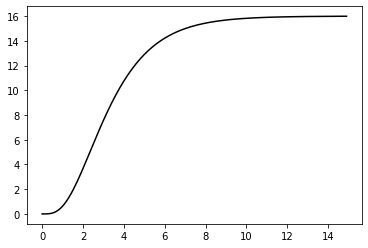

In [11]:
plt.plot(time, g_k*(ode_solution**4), 'k')

/home/mi/thempel/Dokumente/Papers/2019-cecam-msm/notebooks/local.py:59: RuntimeWarning: invalid value encountered in true_divide
  alpha = (0.01*(10.-Vm))/(np.exp((10.-Vm)/10.)-1)


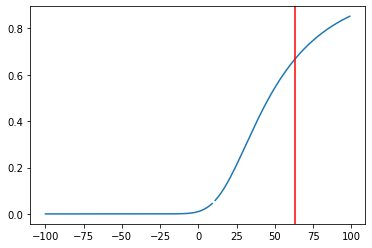

In [12]:
# Plot the steady state open occupancy
vs = np.arange(-100, 100)
plt.plot(vs, kchannel_params(vs)[2]**4)
plt.axvline(V_clamp, color='r')

## model generation & convergence analysis

In [13]:
# Construct a microstate trajectory
msmlag = 0.0001 # in seconds
tot_T = 100000 # Steps

alpha, beta, ss, tau = kchannel_params(V_clamp)
c = Channel(alpha*1000, beta*1000)

In [14]:
Tm = c.transition_matrix(msmlag)
Tm_singlet = c.transition_matrix_singlet(msmlag)

with np.printoptions(precision=4, suppress=True):
    print("Macrostate Transition Matrix:")
    print(Tm, '\n')
    print("single sub-system transition matrix:")
    print(Tm_singlet)

Macrostate Transition Matrix:
[[0.8086 0.1764 0.0144 0.0005 0.    ]
 [0.0047 0.8488 0.1388 0.0076 0.0001]
 [0.     0.0099 0.8904 0.097  0.0026]
 [0.     0.0001 0.0155 0.9335 0.0509]
 [0.     0.     0.0002 0.0217 0.9781]] 

single sub-system transition matrix:
[[0.9483 0.0517]
 [0.0055 0.9945]]


In [15]:
# generate a trajectory in empirical state space 
traj = msmtools.generation.generate_traj(Tm, tot_T)

In [16]:
# is it connected?
# in rare cases, tot_T not large enough to sample all 5 states reversibly
msmtools.estimation.is_connected(msmtools.estimation.count_matrix(traj, 1, sparse_return=False))

True

In [17]:
# generate from sub-system transition matrix (single gate)
singlet_traj = msmtools.generation.generate_traj(Tm_singlet, tot_T)

In [18]:
# Validate that the steady state open probability is as we expect
P_open = np.count_nonzero(traj == 4) / tot_T
print('Empirical P_open:', P_open)
print('SS from eigendecomposition:', msmtools.analysis.stationary_distribution(Tm)[4])
print('from independent sub-systems: ', 
      msmtools.analysis.stationary_distribution(Tm_singlet)[1]**4)

Empirical P_open: 0.67777
SS from eigendecomposition: 0.6664516597482566
from independent sub-systems:  0.6664516597482637


## dMSM vs. MSM comparison
### estimate sampling and convergence

In [19]:
ntrials = 10  # repeat for different realizations to assess error
npoints = 40 # number of points on sampling axis
min_sampling_log = 2 # start conducting relaxation experiment here

p0 = [1, 0, 0, 0, 0] # prepare in closed state
observable = [0, 0, 0, 0, 1] # K conductance

In [20]:
sampling_arr_full = np.zeros((Tm.shape[0]-1+2, ntrials, npoints)) + np.NaN  # classical MSM
sampling_arr_dec = sampling_arr_full.copy() # dMSM

relaxation_arr_full = np.zeros((150, ntrials, npoints)) + np.NaN
relaxation_arr_dec = relaxation_arr_full.copy()

# conduct `ntrials` times the same experiment
for trial in tqdm(range(ntrials)):
    traj = msmtools.generation.generate_traj(Tm, tot_T)

    # when using dMSMs, we'd have a full channel in the simulation box, i.e. four 
    # gates that we extract trajectories of.
    # cannot disassemble above `traj` as information about single channels got
    # lost during empirical state coarse graining
    
    singlet_trajs = msmtools.generation.generate_trajs(Tm_singlet, 4, tot_T) 
    
    for n_end, end in enumerate(np.logspace(min_sampling_log, len(str(tot_T)) -1, npoints)):
        
        # in empirical state space
        ccmat = msmtools.estimation.connected_cmatrix(
            msmtools.estimation.count_matrix(traj[:int(end)], 1, sparse_return=False))

        sampling_arr_full[0, trial, n_end] = msmlag * 1000 * end  # unit: ms
        sampling_arr_full[1, trial, n_end] = ccmat.shape[0] / 5
        
        if ccmat.shape[0] > 1:
            tmat = msmtools.estimation.tmatrix(ccmat)

            sampling_arr_full[2:2+tmat.shape[0]-1, trial, n_end] = msmtools.analysis.timescales(tmat)[1:]

            if tmat.shape[0] == 5:
                msm = pyemma.msm.markov_model(tmat, dt_model='0.1 ms')
                times, rel = msm.relaxation(p0, observable, maxtime=15)
                relaxation_arr_full[:, trial, n_end] = rel

        ccmat, tmat = None, None
        singlet_ccmats = [msmtools.estimation.connected_cmatrix(
            msmtools.estimation.count_matrix(singlet_traj[:int(end)], 1, sparse_return=False))
                           for singlet_traj in singlet_trajs]

        sampling_arr_dec[0, trial, n_end] = msmlag * 1000 * end  # unit: ms
        sampling_arr_dec[1, trial, n_end] = np.mean([ccmat.shape[0] / 2 for ccmat in singlet_ccmats])

        if all([ccmat.shape[0] > 1 for ccmat in singlet_ccmats]): # exclude rare-sampling case that only visited a single state (triggers estimation error)
            singlet_tmats = [msmtools.estimation.tmatrix(ccmat) for ccmat in singlet_ccmats] # subsystem tmatrices
            tmat_full_uncg = np.kron(np.kron(np.kron(singlet_tmats[0], singlet_tmats[1]), singlet_tmats[2]), singlet_tmats[3])
            tmat_full = cg_transition_matrix(tmat_full_uncg, chi)  
            
    
            sampling_arr_dec[2:2+tmat_full.shape[0]-1, trial, n_end] = msmtools.analysis.timescales(tmat_full)[1:]
            
            # tmat_full is fully connected
            msm = pyemma.msm.markov_model(tmat_full, dt_model='0.1 ms')
            times, rel = msm.relaxation(p0, observable, maxtime=15)
            relaxation_arr_dec[:, trial, n_end] = rel            

# occasional errors due to finite sampling can be ignored -> NaNs in output arrary

/storage/mi/thempel/anaconda3/envs/py37_oct19/lib/python3.7/site-packages/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


In [21]:
# since our observable is not normed to be a conductance, we have to
# multiply by a constant factor
# derive from relaxation that uses most data
normalization_factor =  g_k*(ode_solution**4)[-1] / relaxation_arr_dec[-1, :, -1].mean()
print(f"normalization factor: {np.round(normalization_factor, 0)[0].astype(int)}")

normalization factor: 24


### plot convergence and relaxation experiment

In [22]:
plt.matplotlib.rcParams['axes.titlesize'] = 12
plt.matplotlib.rcParams['axes.labelsize'] = 20
plt.matplotlib.rcParams['legend.fontsize'] = 11
plt.matplotlib.rcParams['xtick.labelsize'] = 11
plt.matplotlib.rcParams['ytick.labelsize'] = 11
plt.matplotlib.rcParams['xtick.minor.pad'] = 2
plt.matplotlib.rcParams['xtick.major.pad'] = 3
plt.matplotlib.rcParams['ytick.minor.pad'] = 2
plt.matplotlib.rcParams['ytick.major.pad'] = 3
plt.matplotlib.rcParams['axes.labelpad'] = 1
plt.matplotlib.rcParams['axes.labelsize'] = 11
from matplotlib import rc
rc('text', usetex=False)

In [23]:
def plot_segmented(x, y, cmap, ax=None, norm=None, lw=None, show_cbar=False, **kwargs):
    if ax is None:
        fig, ax =  plt.subplots()
    if norm is None:
        norm = plt.matplotlib.colors.LogNorm(x.min(), x.max())
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    #norm = plt.Normalize(x.min(), x.max())
    
    
    lc = plt.matplotlib.collections.LineCollection(segments, cmap=cmap, norm=norm, **kwargs)
    lc.set_array(x)
    if lw is not None:
        lc.set_linewidth(lw)

    line = ax.add_collection(lc)
    if show_cbar:
        ax.get_figure().colorbar(line, ax=ax)
    return ax

In [24]:
lw = 2.5
ms = 8
alpha = .8
vspanwidthpercentage = 0.06
reduce_max_conductance = 1.  # percentage of max_conductance to scale ylim with
dashes = (5, 5) #(length, spacing)
example_relaxation_curve_indices = [13, 26, 39]

its_ref = msmtools.analysis.timescales(Tm)
sampling_time_ms = sampling_arr_full[0, 0, :]
n_lengths = len(sampling_time_ms)

cmap = plt.matplotlib.cm.viridis_r
norm = plt.matplotlib.colors.LogNorm(sampling_time_ms.min(), sampling_time_ms.max())

cols = cmap(norm(sampling_time_ms))
plot_colorscaled = False

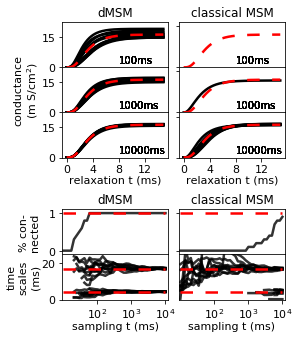

In [25]:

# set up axes
fig = plt.figure(figsize=(4, 5.1))
gs = fig.add_gridspec(6, 2, height_ratios=(1, 1, 1, 1.15, 1, 1), wspace=.1, hspace=.0)
ax_top = np.array([[fig.add_subplot(gs[row, col]) for col in range(2)] for row in range(3)])
ax_placeholder = fig.add_subplot(gs[3, :])  # space holder between upper and other axes
ax_placeholder.axis('off')
ax_mid = [fig.add_subplot(gs[4, 0]), fig.add_subplot(gs[4, 1])]
ax_bottom = [fig.add_subplot(gs[5, n]) for n in range(2)]


for trial in range(ntrials):
    # relaxation plot: subsample to make plot more clear
    for n, index in enumerate(example_relaxation_curve_indices):
        label = f'{int(sampling_time_ms[index])}ms'
        ax_top[n, 0].plot(times, 
                       relaxation_arr_dec[:, trial, index]*normalization_factor, 
                       lw=lw, c=cols[index] if plot_colorscaled else 'k')
        
        ax_top[n, 1].plot(times, 
                       relaxation_arr_full[:, trial, index]*normalization_factor, 
                       lw=lw, c=cols[index] if plot_colorscaled else 'k')
        for _ax in ax_top[n]: _ax.text(8, 2, label)
    
    # implied timescales
    for its_n in [0, 3]:
        if plot_colorscaled:
            plot_segmented(sampling_arr_dec[0, trial], sampling_arr_dec[its_n + 2, trial], cmap, norm=norm, ax=ax_bottom[0], lw=lw, alpha=alpha)
            plot_segmented(sampling_arr_full[0, trial], sampling_arr_full[its_n + 2, trial],cmap, norm=norm, ax=ax_bottom[1], lw=lw, alpha=alpha)
        else:
            ax_bottom[0].plot(sampling_arr_dec[0, trial], sampling_arr_dec[its_n + 2, trial], lw=lw, c='k', alpha=alpha)
            ax_bottom[1].plot(sampling_arr_full[0, trial], sampling_arr_full[its_n + 2, trial], lw=lw, c='k', alpha=alpha)
        
# connectivity
if plot_colorscaled:
    plot_segmented(sampling_arr_full[0, 0], (sampling_arr_full[1, :] == 1).astype(float).mean(axis=0), cmap, ax=ax_mid[1], norm=norm, lw=lw, alpha=alpha)
    plot_segmented(sampling_arr_dec[0, 0], (sampling_arr_dec[1, :] == 1).astype(float).mean(axis=0), cmap, ax=ax_mid[0], norm=norm, lw=lw, alpha=alpha)
else:
    ax_mid[1].plot(sampling_arr_full[0, 0], (sampling_arr_full[1, :] == 1).astype(float).mean(axis=0), lw=lw, c='k', alpha=alpha)
    ax_mid[0].plot(sampling_arr_dec[0, 0], (sampling_arr_dec[1, :] == 1).astype(float).mean(axis=0), lw=lw, c='k', alpha=alpha)
    
# set labels
for _ax in [ax_top[0, 0], ax_mid[0]]:
    _ax.set_title('dMSM')
for _ax in [ax_top[0, 1], ax_mid[1]]:
    _ax.set_title('classical MSM')
ax_top[1, 0].set_ylabel('conductance\n' + r'(m S/cm${}^2$)', va='bottom')
ax_mid[0].set_ylabel('% con-\nnected')
ax_bottom[0].set_ylabel('time\nscales\n(ms)')
#ax_bottom[0].set_ylabel('its/ms')

# sharex = True for connectivity and its plots
for _ax in np.concatenate([ax_bottom, ax_mid]):
    _ax.semilogx()
    _ax.set_xlim(0.9*sampling_arr_full[0, 0, 0], 
                 1.2*sampling_arr_full[0, 0, -1])

# relaxation plot: reference, labels, sharey
relax_ylabels = [0, 15]
ymax_relax = reduce_max_conductance * max(relaxation_arr_dec[-1, :, :][np.isfinite(relaxation_arr_dec[-1, :, :])].max(), relaxation_arr_full[-1, :, :][np.isfinite(relaxation_arr_full[-1, :, :])].max()) * normalization_factor
for _nax, _ax in enumerate(ax_top[2]):
    _ax.plot(time, g_k*(ode_solution**4), 'r', linestyle='--', dashes=dashes, #label='reference' if _nax == 0 else None, 
             lw=lw, zorder=100)
    _ax.set_xticks(np.arange(0, 16, 4))
    _ax.set_xlabel('relaxation t (ms)')
    _ax.set_ylim(0, 
                 ymax_relax)
    if _nax == 1:
        _ax.set_yticklabels([])
    else:
        _ax.set_yticks(relax_ylabels)

for _nax, _ax in enumerate(ax_top[0].tolist() + ax_top[1].tolist()):
    _ax.plot(time, g_k*(ode_solution**4), 'r', linestyle='--', dashes=dashes, #label='reference' if _nax == 0 else None, 
             lw=lw, zorder=100)
    _ax.set_xticks(np.arange(0, 16, 4))
    _ax.set_xlabel('relaxation t (ms)')
    _ax.set_ylim(0, ymax_relax)
    if _nax % 2 == 1:             
        _ax.set_yticklabels([])
    else:
        _ax.set_yticks(relax_ylabels)


# connectivity plot: reference, xlabels, ylim
for _nax, _ax in enumerate(ax_mid):
    _ax.plot(sampling_arr_dec[0, trial], [1 for _ in sampling_arr_dec[0, trial]], 'r', linestyle='--', dashes=dashes,
             lw=lw, zorder=100)
    _ax.set_xlabel('')
    _ax.set_xticks([])
    _ax.set_ylim(-0.1, 1.1)
    if _nax == 1:
        _ax.set_yticklabels([])
    
# its plots: reference, xlabels, ylim
for _nax, _ax in enumerate(ax_bottom):
    _ax.set_xlabel(f'sampling t (ms)')
    _ax.set_ylim(0, 25)
    _ax.set_xticks(sampling_time_ms[example_relaxation_curve_indices])
    _ax.plot([sampling_arr_full[0, 0, 0], sampling_arr_full[0, 0, -1]], [its_ref[1], its_ref[1]],
                    lw=lw, linestyle='--', zorder=100, color='r', dashes=dashes)
    
    _ax.plot([sampling_arr_full[0, 0, 0], sampling_arr_full[0, 0, -1]], [its_ref[4], its_ref[4]],
                        lw=lw, linestyle='--', zorder=100, color='r', dashes=dashes)
    if _nax == 1:
        _ax.set_yticklabels([])
        _ax.set_yticks([])

fig.align_ylabels([ax_top[1, 0], ax_mid[0], ax_bottom[0]])

## decomposed MSM example
Here we show at example how to compute a full MSM from submodels and to access full system experimental observables.

In [26]:
end = 7500
print(f'using {end * msmlag * 1000} ms sampling time')

using 750.0 ms sampling time


In [27]:
# subsystem count matrices
singlet_ccmats = [msmtools.estimation.connected_cmatrix(
    msmtools.estimation.count_matrix(singlet_traj[:int(end)], 1, sparse_return=False))
                   for singlet_traj in singlet_trajs]
print(f'{100*np.mean([ccmat.shape[0] / 2 for ccmat in singlet_ccmats])} % connected')

# subsystem transition matrices
singlet_tmats = [msmtools.estimation.tmatrix(ccmat) for ccmat in singlet_ccmats]       

# full system transition matrix on all 16 combinatorial states
tmat_full_uncg = np.kron(np.kron(np.kron(singlet_tmats[0], singlet_tmats[1]), singlet_tmats[2]), singlet_tmats[3])

# full system transition matrix in empirical state formulation
tmat_full = cg_transition_matrix(tmat_full_uncg, chi) 

100.0 % connected


In [28]:
# tmat_full is fully connected
msm = pyemma.msm.markov_model(tmat_full, dt_model='0.1 ms')

# relaxation experiment (to reproduce electropysiology)
times, rel = msm.relaxation(p0, observable, maxtime=15)
assert np.all(times == time)

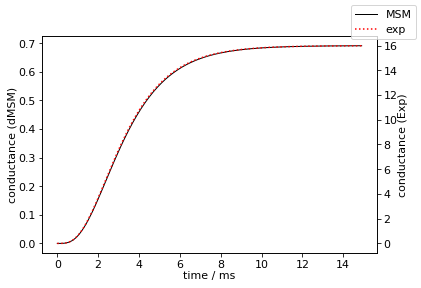

In [29]:
fig, ax = plt.subplots()

ax.plot(times, rel, 'k', linewidth=1, label='MSM')
tax = ax.twinx()
tax.plot(time, g_k*(ode_solution**4), 'r:', label='exp')
ax.set_ylabel('conductance (dMSM)')
tax.set_ylabel('conductance (Exp)')
ax.set_xlabel('time / ms')
fig.legend()

# this plot does not include scaling of relaxation observable to conductance as above